# **🏦 Loan Approval Prediction**

Este notebook apresenta uma solução completa de **Machine Learning** voltada para prever a aprovação de empréstimos bancários e, para os casos aprovados, estimar a **taxa de juros (interest rate)** ajustada ao perfil de cada cliente.

No setor financeiro, decisões de crédito precisam ser rápidas, consistentes e baseadas em critérios sólidos. Uma análise bem estruturada reduz riscos, melhora a eficiência operacional e possibilita que instituições ofereçam condições mais alinhadas à capacidade real de pagamento do cliente.  
Esse projeto demonstra como modelos de classificação e regressão podem atuar juntos para apoiar esse processo de forma estratégica.

Construímos aqui uma pipeline robusta capaz de:

- Identificar clientes com maior probabilidade de aprovação  
- Estimar a taxa de juros ideal com base em características financeiras  
- Auxiliar na padronização das decisões de crédito  
- Apoiar análises de risco e otimização de políticas internas  

---

# **📘 Contexto e Propósito**

Conceder crédito é um dos pilares do mercado financeiro — porém, decisões incorretas podem gerar custos elevados e impacto direto na inadimplência.  
Um sistema automatizado de aprovação contribui para:

- Processos de avaliação mais seguros  
- Menos subjetividade nas decisões  
- Uso eficiente de dados históricos e comportamentais  
- Definição mais precisa de taxas de juros  

Além disso, compreender as variáveis que influenciam a aprovação é essencial para ajustar critérios internos e melhorar o atendimento ao cliente.

---

# **🔧 Abordagem Técnica**

A construção do modelo segue uma estrutura organizada e replicável de Ciência de Dados:

1. **Carregamento das bibliotecas e inspeção do dataset**  
- Pandas, scikit-learn, seaborn e xgboost

2. **Análise exploratória (EDA)** com gráficos e estatísticas descritivas  
- Geração de gráficos das variáveis e suas relações com a variável approval
- distribuição das variáveis numéricas e categóricas e análises estatísticas
3. **Pré-processamento das variáveis:**  
- Tratamento de valores ausentes com *KNN Imputer*  
- Codificação com *OrdinalEncoder*  
- Análise de correlação com o alvo  
4. **Modelagem de classificação** usando GridSearchCV e métricas como precisão, recall e F1-score  
5. **Modelos de regressão (Linear & Lasso)** para prever *interest rate*  
6. **Predições reais para validação final**

---

# **📑 Sobre o dataset :**

A tabela abaixo apresenta todas as variáveis utilizadas no dataset, com descrição e tradução:

| Feature | Tradução | Descrição |
|--------|----------|-----------|
| **age** | *idade* | Idade do cliente. |
| **salary** | *salário* | Renda mensal aproximada do cliente. |
| **employment_status** | *status de emprego* | Situação profissional (empregado, autônomo, desempregado etc.). |
| **credit_score** | *pontuação de crédito* | Score que representa o histórico de crédito e comportamento financeiro. |
| **Previous_Delinquencies** | *inadimplências anteriores* | Número de ocorrências passadas de atraso ou não pagamento. |
| **loan_amount** | *valor do empréstimo* | Valor solicitado pelo cliente. |
| **Loan_Term_Months** | *prazo do empréstimo (meses)* | Total de meses para quitar o empréstimo. |
| **Existing_Loans_Count** | *quantidade de empréstimos ativos* | Número de empréstimos que o cliente já possui atualmente. |
| **debt_to_income** | *relação dívida/renda* | Proporção entre despesas e renda mensal; indicador comum em análise de crédito. |
| **Savings_Account** | *conta poupança* | Indica se o cliente possui poupança (sim/não). |
| **interest_rate** | *taxa de juros* | Taxa aplicada para o empréstimo aprovado  (variável alvo da regressão). |
| **approved** | *aprovado* | Indica se o empréstimo foi aprovado (1) ou não (0). |
| **gender** | *gênero* | Gênero do cliente. |


⚠️ Importante: nesta base de dados, o interest_rate não representa juros mensais, mas sim a **taxa total do contrato**, ou seja:

Se o empréstimo tem taxa de 9%, isso significa que o cliente pagará 9% sobre o valor total emprestado, independentemente do prazo (7, 12, 30 meses etc.).


## 1. Importações iniciais e primeiro contato com o dataset :

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
import pickle



color_palette = ['#14213d', '#fca311', "#a5a4a4", '#ffffff']


df = pd.read_excel("../data/Loan_dataset.xlsx")


In [2]:
df.head(10)

,ID,age,salary,employment_status,credit_score,Previous_Delinquencies,loan_amount,Loan_Term_Months,Existing_Loans_Count,debt_to_income,Savings_Account,interest_rate,approved,cpf,gender
0,1,53.0,8700,employed,980.0,0.0,327384,41,1,0.419,no,3.34,1,67848190009,M
1,2,49.0,3200,employed,764.0,0.0,122367,34,2,0.370,no,8.23,1,99369029521,F
2,3,49.0,1900,unemployed,728.0,0.0,67093,30,1,0.273,no,0.00,0,47963924957,F
3,4,21.0,7800,unemployed,549.0,3.0,82513,23,1,0.041,no,0.00,0,31443410399,F
4,5,35.0,4600,autonomous,772.0,0.0,65891,8,0,0.301,no,7.02,1,42230126999,M
5,6,66.0,2400,employed,718.0,0.0,23104,23,1,0.778,no,0.00,0,24614684979,M
6,7,36.0,5200,employed,524.0,3.0,205161,12,0,0.439,yes,0.00,0,69295443216,F
7,8,60.0,1800,unemployed,612.0,0.0,11754,33,1,0.291,no,0.00,0,98687509502,M
8,9,69.0,7700,employed,589.0,2.0,115325,22,0,0.305,yes,10.14,1,77058163464,F
9,10,52.0,3000,employed,634.0,1.0,25087,30,0,0.554,no,10.43,1,29969253853,M


In [3]:
df.columns

Index(['ID', 'age', 'salary', 'employment_status', 'credit_score',
       'Previous_Delinquencies', 'loan_amount', 'Loan_Term_Months',
       'Existing_Loans_Count', 'debt_to_income', 'Savings_Account',
       'interest_rate', 'approved', 'cpf', 'gender'],
      dtype='object')

### 1.1 Deletando colunas sem relevância : 

In [4]:
df.drop(columns = ['ID', 'cpf'], inplace=True)

### 1.2 Informações estatísticas do dataset : 

In [5]:
df.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
age,4850.00,49.26,18.24,18.00,34.00,49.00,65.00,80.00
salary,5000.00,5461.74,2704.01,800.00,3100.00,5500.00,7800.00,10000.00
credit_score,4850.00,641.68,183.12,300.00,508.00,610.00,796.00,1000.00
Previous_Delinquencies,4900.00,1.05,1.44,0.00,0.00,0.00,2.00,4.00
loan_amount,5000.00,111615.65,89135.75,757.00,38116.25,87446.00,167063.50,394998.00
Loan_Term_Months,5000.00,26.89,12.45,6.00,16.00,27.00,38.00,48.00
Existing_Loans_Count,5000.00,0.99,1.00,0.00,0.00,1.00,2.00,5.00
debt_to_income,5000.00,0.50,0.29,0.00,0.24,0.49,0.75,1.00
interest_rate,5000.00,1.73,3.44,0.00,0.00,0.00,0.00,14.08
approved,5000.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


A análise estatística mostra que o conjunto de dados apresenta padrões típicos do contexto financeiro. Variáveis como salary (**média ≈ 5.4k, máx: 10k, min : 800** ) e loan_amount (**média ≈ 111k, máx. 394k**) possuem alta variabilidade, refletindo perfis diversos de clientes — desde rendas mais baixas até solicitações de crédito elevadas. 

Apesar da presença de valores altos em algumas features, **não é necessário normalizar os dados ou tratar outliers**, pois os modelos empregados — **DecisionTreeClassifier, RandomForestClassifier e XGBoostClassifier** — são baseados em árvores e, portanto, robustos a outliers e independentes da escala das variáveis. Dessa forma, as variáveis podem ser utilizadas diretamente sem pré-processamentos adicionais.

## 2. Análise Exploratória de Dados (EDA)

### 2.1 Distribuição da variável alvo :

approved
0    3813
1    1187
Name: count, dtype: int64


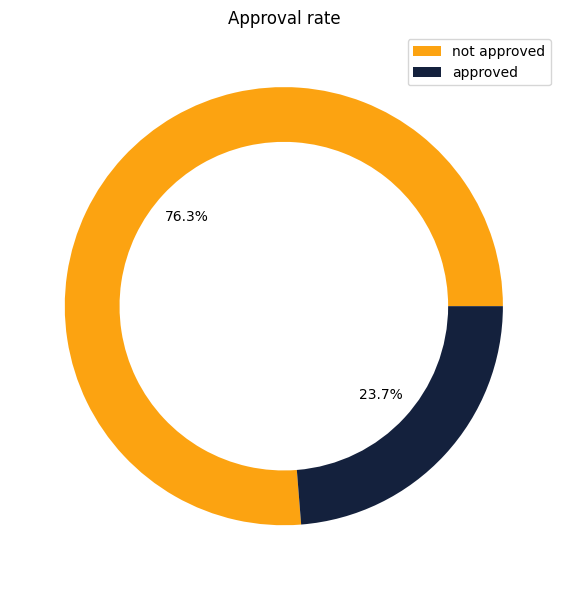

In [6]:
approved_counts = df.approved.value_counts()
print(approved_counts)
plt.figure(figsize=(12,6))
plt.pie(approved_counts,autopct='%1.1f%%', wedgeprops=dict(width=0.25), colors=['#fca311', '#14213d'])
plt.legend(['not approved', 'approved'])
plt.title('Approval rate')

plt.tight_layout()
plt.show()


O plot da distribuição das classes (approved vs not approved) mostra que o dataset é desbalanceado, com 76.3% de exemplos da classe não aprovada e 23.7% da classe aprovada. No entanto, neste ponto do código ainda não é possível determinar se será necessário aplicar técnicas de balanceamento, pois essa decisão depende do desempenho do modelo, que será avaliado nas etapas seguintes.

🎯 Utilizando métricas mais adequadas

Antes de balancear a variável, utilizaremos métricas que lidam melhor com desbalanceamento, como:

- **Precision**  
- **Recall**  
- **F1-Score**  
- **AUC-ROC**  

Essas métricas oferecem uma visão muito mais clara do desempenho real do modelo, especialmente para identificar corretamente clientes que podem ser aprovados.

### 2.2 Distribuições das idades e do score de crédito e relacionamento com o alvo :

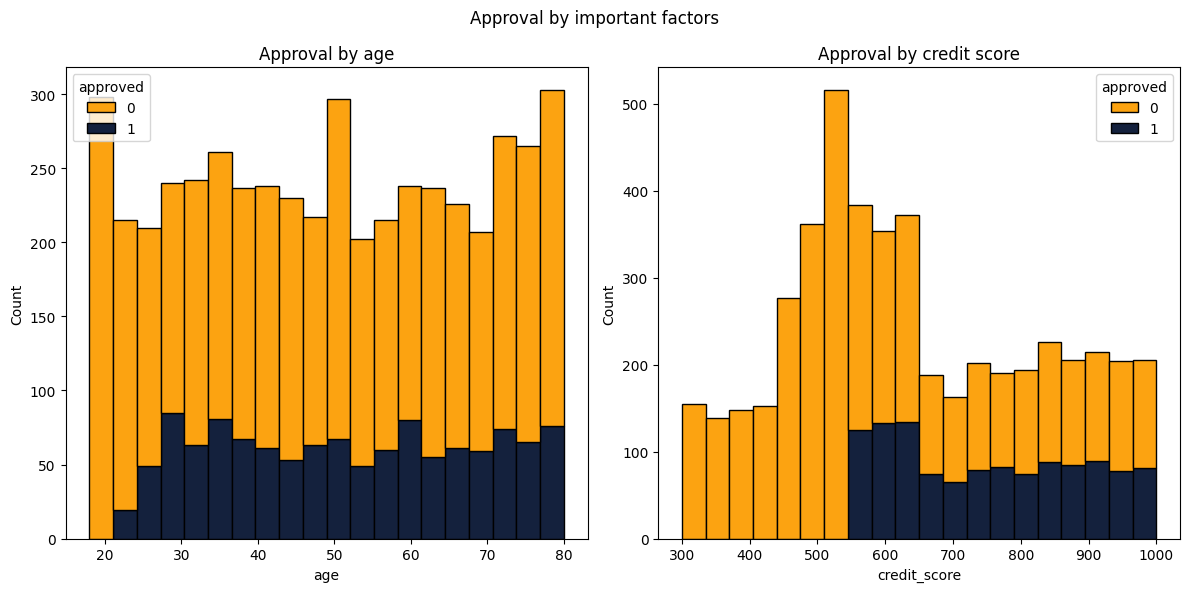

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

sns.histplot(
    data=df, x='age', bins=20, hue='approved',
    multiple='stack', palette=['#fca311', '#14213d'],
    edgecolor='black', ax=axes[0], alpha=1
)

sns.histplot(
    data=df, x='credit_score', bins=20, hue='approved',
    multiple='stack', palette=['#fca311', '#14213d'],
    edgecolor='black', ax=axes[1], alpha=1
)

axes[0].set_title('Approval by age')
axes[1].set_title('Approval by credit score')

plt.suptitle('Approval by important factors')
plt.tight_layout()
plt.show()


In [ ]:
min_age_approved = df.loc[df["approved"] == 1, "age"].min()
print("Idade mínima de aprovação:", min_age_approved)

Idade mínima de aprovação: 24.0


Podemos notar que há idade e score mínimo para a aprovação do empréstimo :
- Para a idade o mínimo necessário é o cliente ter 24 anos
- Para score de crédito fica explícito pelo gráfico 2 que o limiar são 550 pontos

### 2.3 Distribuição por fatores chaves : 

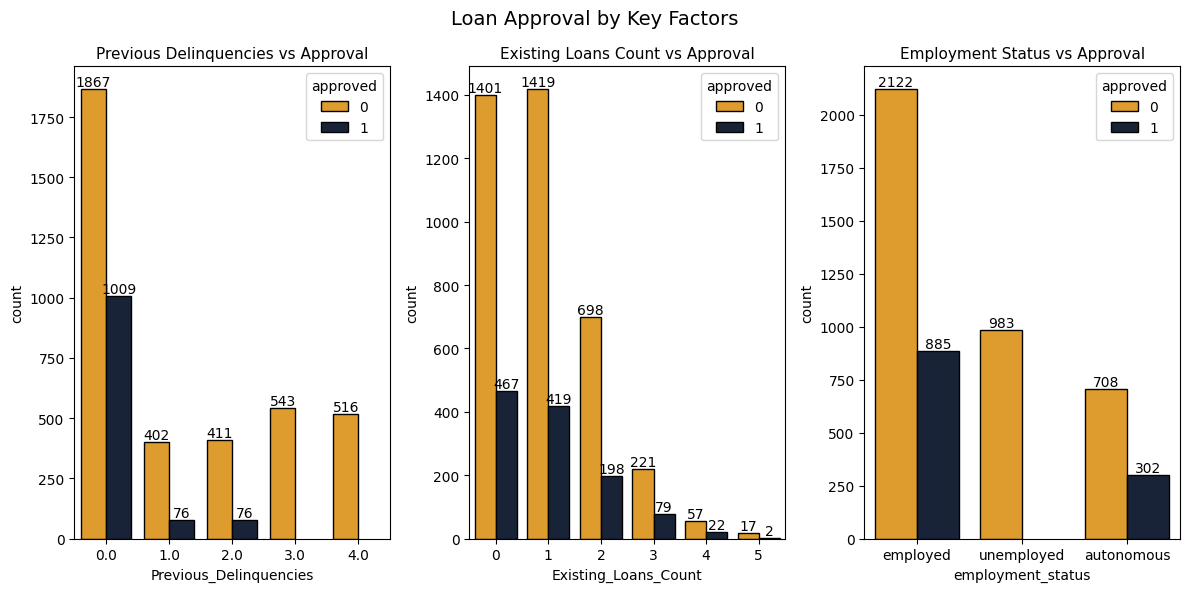

In [9]:
fig, axes = plt.subplots(1,3, figsize=(12,6))

sns.countplot(
    data=df, x='Previous_Delinquencies', hue='approved',
    palette=['#fca311', '#14213d'],
    edgecolor='black', ax=axes[0], alpha=1 )

sns.countplot(
    data=df, x='Existing_Loans_Count', hue='approved',
    palette=['#fca311', '#14213d'],
    edgecolor='black', ax=axes[1], alpha=1
)

sns.countplot(
    data=df, x='employment_status', hue='approved',
    palette=['#fca311', '#14213d'],
    edgecolor='black', ax=axes[2], alpha=1
)

for ax in axes:
    for container in ax.containers:  
        ax.bar_label(container)

axes[0].set_title('Previous Delinquencies vs Approval', fontsize=11)
axes[1].set_title('Existing Loans Count vs Approval', fontsize=11)
axes[2].set_title('Employment Status vs Approval', fontsize=11)

fig.suptitle('Loan Approval by Key Factors', fontsize=14)
plt.tight_layout()
plt.show()

 #### Delinquências prévias :
 A análise das delinquências evidencia de forma clara que **quanto menor o histórico de problemas bancários, maior a chance de aprovação**:

- **0 delinquências:**  
  - Aprovação de aproximadamente **54%** dos clientes.  
  - Total de **1009** pessoas neste grupo.

- **1 delinquência:**  
  - A taxa de aprovação cai drasticamente para **18,9%**, representando quase **3 vezes menos** do que o grupo sem inadimplência.

- **2 delinquências:**  
  - Mantém uma **porcentagem muito semelhante** ao grupo com 1 delinquência, reforçando a dificuldade de aprovação.

- **3 ou mais delinquências:**  
  - **Nenhum cliente foi aprovado** — um indicativo forte de que a instituição não aceita esse nível de risco.

##### Inadimplentes vs. não inadimplentes  :

- **2.876 clientes** não possuem histórico de inadimplência — isso representa **57,52%** de toda a base.
- **2.124 clientes** apresentam algum tipo de problema prévio — equivalentes a **42,48%** do total.

Entre os **1.161 clientes aprovados**:

- **86,9%** pertencem ao grupo **sem delinquências**.  
- Apenas **13,1%** das aprovações são provenientes de clientes com histórico de problemas.


 #### Número de empréstimos atuais : 

 - Esta coluna não parece interferir muito na aprovação, visto que a porcentagem aceita é similar para qualquer quantidade de empréstimos que o cliente tem atualmente, exceto quando o valor é 5 .
##### Porcentagem aceita : 
- 0 : 33,3% , 1: 29,5% , 2 : 28,4% , 3 : 35,0% , 4 : 38,5% , 5 : 11,9 %


#### situação de emprego :
Pelo histograma podemos notar que a instituição não aprova clientes em situção de desemprego. A taxa de aceitação de empréstimo para empregados e autônomos são parecidas, 41,7% e 42,6% respectivamente (aproximadamente)



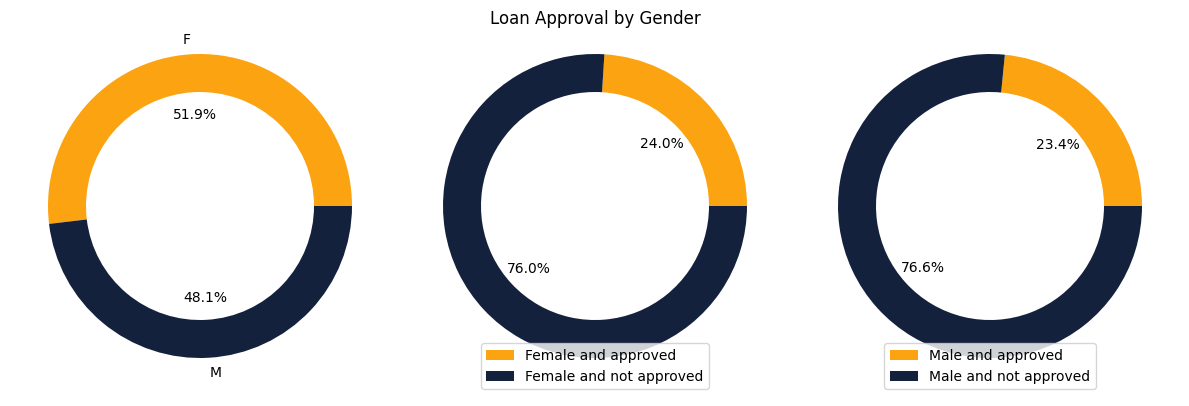

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), constrained_layout=True)

gender_count  = df.gender.value_counts()

F_approved = df[(df['approved'] == 1) & (df['gender'] == 'F')].shape[0]
F_notapproved = df[(df['approved'] == 0) & (df['gender'] == 'F')].shape[0]
M_approved = df[(df['approved'] == 1) & (df['gender'] == 'M')].shape[0]
M_notapproved = df[(df['approved'] == 0) & (df['gender'] == 'M')].shape[0]

axes[0].pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', wedgeprops=dict(width=0.25), colors=['#fca311', '#14213d'])
axes[1].pie([F_approved, F_notapproved], autopct='%1.1f%%', wedgeprops=dict(width=0.25), colors=['#fca311', '#14213d'])
axes[1].legend(labels=['Female and approved', 'Female and not approved'], loc='lower center')
axes[2].pie([M_approved, M_notapproved], autopct='%1.1f%%', wedgeprops=dict(width=0.25), colors=['#fca311', '#14213d'])
axes[2].legend(labels=['Male and approved', 'Male and not approved'], loc='lower center')

fig.suptitle('Loan Approval by Gender', y=0.8)
plt.tight_layout()
plt.show()


A distribuição de cada gênero é bem distribuída e a aprovação para cada sexo é muito parecida

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     4850 non-null   float64
 1   salary                  5000 non-null   int64  
 2   employment_status       5000 non-null   object 
 3   credit_score            4850 non-null   float64
 4   Previous_Delinquencies  4900 non-null   float64
 5   loan_amount             5000 non-null   int64  
 6   Loan_Term_Months        5000 non-null   int64  
 7   Existing_Loans_Count    5000 non-null   int64  
 8   debt_to_income          5000 non-null   float64
 9   Savings_Account         5000 non-null   object 
 10  interest_rate           5000 non-null   float64
 11  approved                5000 non-null   int64  
 12  gender                  5000 non-null   object 
dtypes: float64(5), int64(5), object(3)
memory usage: 507.9+ KB


Possuímos dados faltantes nas colunas age (150), credit_score (150) e previous_delinquencies (100). A coluna credit_score pode estar altamente correlacionada com previous_delinquencies, já que delinquências anteriores influenciam diretamente o score e vice-versa. Por isso, podemos utilizar o KNN Imputer para preencher credit_score com base em previous_delinquencies e também o oposto, já que existe uma relação plausível entre essas variáveis. Nesse caso, o tipo de mecanismo de ausência é classificado como Missing At Random (MAR), pois os dados faltantes parecem depender de outras variáveis observáveis do conjunto de dados

Para a coluna age, podemos utilizar a mediana, pois a distribuição é aproximadamente normal e a instituição só não aprova solicitações quando a idade é menor que 21 anos — como a mediana é superior a esse valor, não há risco de distorcer a regra de aprovação.

## 3 Pré-processamento : 

### 3.1 Decodificação das variáveis categóricas :

In [12]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

df[['gender', 'Savings_Account', 'employment_status']] = ordinal_encoder.fit_transform(
    df[['gender', 'Savings_Account', 'employment_status']]
)

Utilizei o OrdinalEncoder para transformar as variáveis categóricas (gender, Savings_Account e employment_status) em valores numéricos. Modelos baseados em árvores — como Decision Trees, Random Forest e XGBoost — não dependem da escala dos dados e não assumem relações lineares entre as features.

Por esse motivo, eles conseguem lidar muito bem com codificações ordinais simples, interpretando apenas a separação entre categorias, e não o valor numérico em si.
Além disso, o OrdinalEncoder é mais eficiente que o OneHotEncoder nesse contexto, pois:

- evita a criação de dezenas de colunas dummy;

- reduz a dimensionalidade do dataset;

- diminui o risco de overfitting devido à explosão de variáveis;

- acelera o treinamento dos modelos de árvore, que já funcionam bem com codificação ordinal.

##### visualizando :

In [13]:
df[['gender', 'Savings_Account', 'employment_status']]

,gender,Savings_Account,employment_status
0,1.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,2.0
3,0.0,0.0,2.0
4,1.0,0.0,0.0
...,...,...,...
4995,1.0,0.0,2.0
4996,0.0,1.0,2.0
4997,0.0,1.0,1.0
4998,1.0,1.0,2.0


#### visualizando alguns dados faltantes :

In [14]:
df_missing = df[df.age.isna() | df.credit_score.isna() | df.Previous_Delinquencies.isna() ]
df_missing.sample(5, random_state=0)

,age,salary,employment_status,credit_score,Previous_Delinquencies,loan_amount,Loan_Term_Months,Existing_Loans_Count,debt_to_income,Savings_Account,interest_rate,approved,gender
1643,NaN,2200,0.0,933.0,0.0,68451,12,1,0.578,1.0,0.0,0,1.0
3733,51.0,7500,1.0,NaN,0.0,29385,44,0,0.811,0.0,0.0,0,0.0
4201,47.0,4600,2.0,NaN,3.0,66492,43,1,0.062,0.0,0.0,0,0.0
2370,NaN,9700,2.0,668.0,0.0,42131,31,1,0.080,0.0,0.0,0,1.0
2954,42.0,1000,0.0,907.0,NaN,3915,29,0,0.810,1.0,0.0,0,1.0


#### Verificando se score de crédito está correlacionado com delinquências prévias :

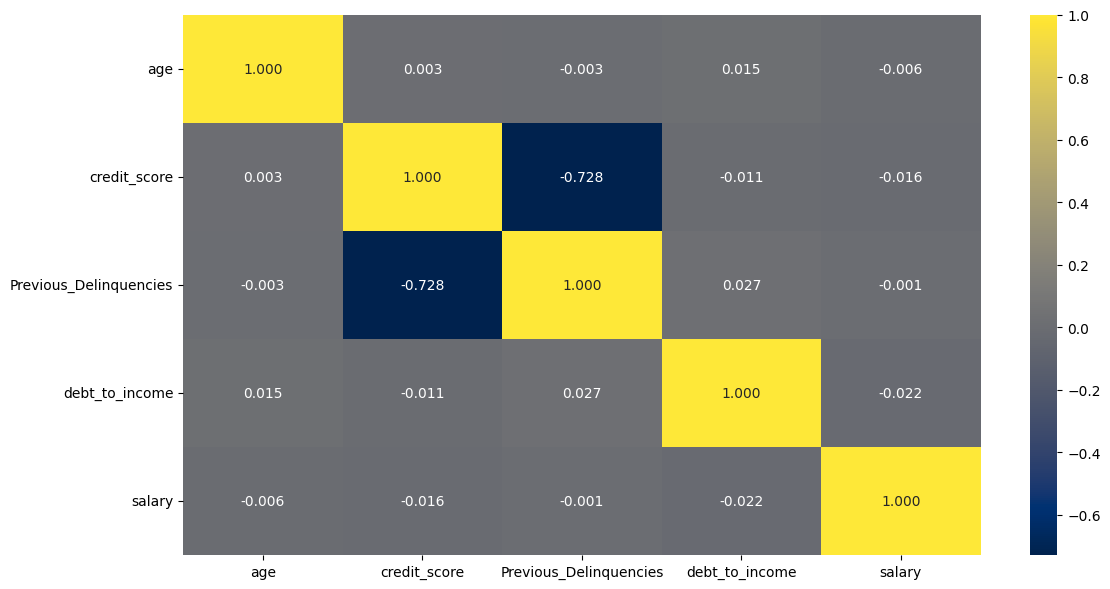

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

correlation_matrix = df[['age','credit_score','Previous_Delinquencies','debt_to_income','salary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.3f')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Podemos concluir que está, então iremos seguir com o método de preenchimento utilizano o KNN imputer visto que é um caso de missing at random (MAR, os dados faltantes parecem depender de outras variáveis observáveis do conjunto de dados)

#### 3.2 Separando em treino e teste :

In [16]:
x = df.drop(columns = ['approved', 'interest_rate'])
y = df['approved']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=0)

Separamos treino e teste antes da imputação para evitar data leakage, garantindo que o imputador aprenda apenas com o treino e não use informações do teste.
- Dividir antes da imputação evita vazamento de informação (Data leakage) e garante que o teste realmente represente novos dados nunca vistos pelo modelo.


##### visualizando :

In [17]:
print("Faltantes no treino:")
print(x_train.isna().sum())

print("\nFaltantes no teste:")
print(x_test.isna().sum())


Faltantes no treino:
age                        97
salary                      0
employment_status           0
credit_score              108
Previous_Delinquencies     72
loan_amount                 0
Loan_Term_Months            0
Existing_Loans_Count        0
debt_to_income              0
Savings_Account             0
gender                      0
dtype: int64

Faltantes no teste:
age                       53
salary                     0
employment_status          0
credit_score              42
Previous_Delinquencies    28
loan_amount                0
Loan_Term_Months           0
Existing_Loans_Count       0
debt_to_income             0
Savings_Account            0
gender                     0
dtype: int64


### 3.3 Preenchiento dos dados faltantes :

In [18]:
x_train.age.fillna(df.age.median(), inplace=True)
x_test.age.fillna(df.age.median(), inplace=True)


imputer = KNNImputer(n_neighbors=5)

x_train[['credit_score','Previous_Delinquencies','debt_to_income']] = imputer.fit_transform(
    x_train[['credit_score','Previous_Delinquencies','debt_to_income']]
)

x_test[['credit_score','Previous_Delinquencies','debt_to_income']] = imputer.fit_transform(
    x_test[['credit_score','Previous_Delinquencies','debt_to_income']]
)

In [19]:
print("Dados faltantes no treino : ")
print(x_train[['age', 'credit_score','Previous_Delinquencies','debt_to_income']].isna().sum())
print("\nDados faltantes no teste : ")
print(x_test[['age', 'credit_score','Previous_Delinquencies','debt_to_income']].isna().sum())


Dados faltantes no treino : 
age                       0
credit_score              0
Previous_Delinquencies    0
debt_to_income            0
dtype: int64

Dados faltantes no teste : 
age                       0
credit_score              0
Previous_Delinquencies    0
debt_to_income            0
dtype: int64


#### 3.4 Correlação entre as variáveis e o alvo : 

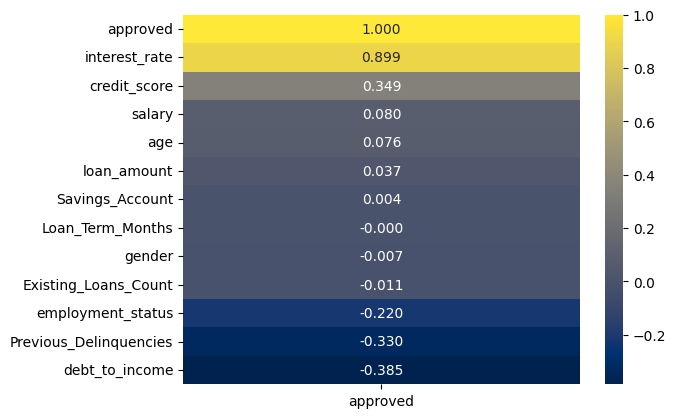

In [20]:
approval_corr = df.corr()[['approved']].sort_values(by='approved', ascending=False)
sns.heatmap(approval_corr, annot=True, cmap='cividis', fmt='.3f')
plt.show()

In [ ]:
models = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy']
        }
    }
}

scores = []

for model_name, mp in models.items():
    results = GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False)
    results.fit(x_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': results.best_score_,
        'best_params': results.best_params_
    })



          model  best_score                                        best_params
0  RandomForest    0.983428  {'max_depth': 20, 'min_samples_leaf': 2, 'min_...
1       XGBoost    0.985142  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
2  DecisionTree    0.984000  {'criterion': 'gini', 'max_depth': 5, 'min_sam...


In [22]:
best_model = results.best_estimator_
train_score = best_model.score(x_train, y_train)
test_score = best_model.score(x_test, y_test)

print("Train score:", train_score)
print("Test score:", test_score)


Train score: 0.9845714285714285
Test score: 0.98


In [23]:
best_model

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1150
           1       0.92      1.00      0.96       350

    accuracy                           0.98      1500
   macro avg       0.96      0.99      0.97      1500
weighted avg       0.98      0.98      0.98      1500



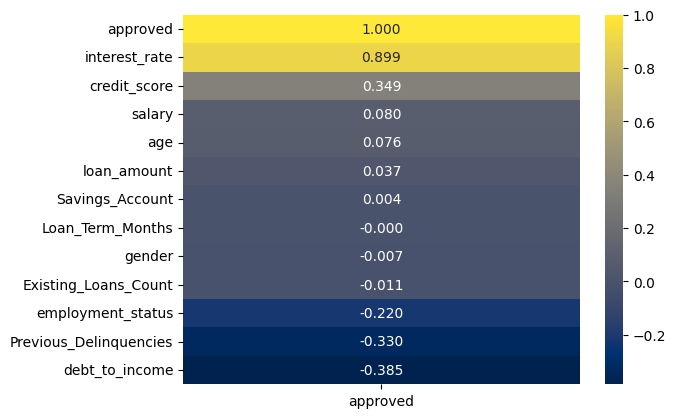

In [25]:
approval_corr = df.corr()[['approved']].sort_values(by='approved', ascending=False)
sns.heatmap(approval_corr, annot=True, cmap='cividis', fmt='.3f')
plt.show()

In [26]:
import pandas as pd

feature_names = x_train.columns  

importances = best_model.feature_importances_

feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)


                   Feature  Importance
3             credit_score    0.352833
8           debt_to_income    0.227945
2        employment_status    0.206404
1                   salary    0.106711
0                      age    0.106106
5              loan_amount    0.000000
4   Previous_Delinquencies    0.000000
6         Loan_Term_Months    0.000000
7     Existing_Loans_Count    0.000000
9          Savings_Account    0.000000
10                  gender    0.000000


In [27]:
approved_df = df[df['approved'] == 1].copy()

X = approved_df.drop(columns=['approved', 'interest_rate'])  
y = approved_df['interest_rate']                              


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.3, random_state=0
)


X_train_reg['age'].fillna(df['age'].median(), inplace=True)
X_test_reg['age'].fillna(df['age'].median(), inplace=True)

imputer = KNNImputer(n_neighbors=5)
cols_impute = ['credit_score', 'Previous_Delinquencies', 'debt_to_income']

X_train_reg[cols_impute] = imputer.fit_transform(X_train_reg[cols_impute])
X_test_reg[cols_impute] = imputer.transform(X_test_reg[cols_impute])

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1)
}


results_reg = {}

for name, model in models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    results_reg[name] = {
        "R²": r2_score(y_test_reg, y_pred_reg),
        "MAE": mean_absolute_error(y_test_reg, y_pred_reg)
    }


results_df = pd.DataFrame(results_reg).T
print(results_df)


                         R²       MAE
Linear Regression  0.997680  0.077569
Lasso Regression   0.960183  0.524134


Métricas de desempenho 
Treino  R²: 0.9990 | MAE: 0.0708
Teste   R²: 0.9977 | MAE: 0.0776


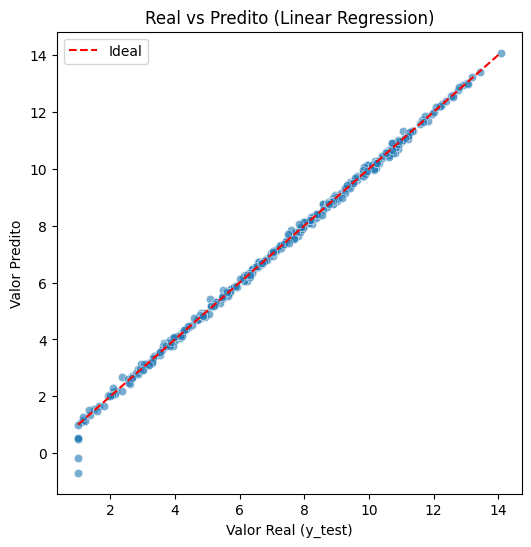

In [28]:
model = LinearRegression()
model.fit(X_train_reg, y_train_reg)

y_train_pred_reg = model.predict(X_train_reg)
y_test_pred_reg = model.predict(X_test_reg)


train_r2 = r2_score(y_train_reg, y_train_pred_reg)
test_r2 = r2_score(y_test_reg, y_test_pred_reg)
train_mae = mean_absolute_error(y_train_reg, y_train_pred_reg)
test_mae = mean_absolute_error(y_test_reg, y_test_pred_reg)

print("Métricas de desempenho ")
print(f"Treino  R²: {train_r2:.4f} | MAE: {train_mae:.4f}")
print(f"Teste   R²: {test_r2:.4f} | MAE: {test_mae:.4f}")


plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_reg, y=y_test_pred_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', label='Ideal')
plt.xlabel('Valor Real (y_test)')
plt.ylabel('Valor Predito')
plt.title('Real vs Predito (Linear Regression)')
plt.legend()
plt.show()


In [29]:
result = pd.concat([X_test_reg.iloc[[0]], y_test_reg.iloc[[0]].rename('interest_rate')], axis=1)
result

,age,salary,employment_status,credit_score,Previous_Delinquencies,loan_amount,Loan_Term_Months,Existing_Loans_Count,debt_to_income,Savings_Account,gender,interest_rate
3496,66.0,2200,1.0,693.0,0.0,21714,42,2,0.185,1.0,0.0,7.52


In [34]:
sample = X_test_reg.iloc[[0]]
real_value = y_test_reg.iloc[0]

pred_value = model.predict(sample)[0]

print(f"🔹 Valor Real: {real_value}")
print(f"🔹 Valor Previsto: {pred_value:.3f}")
print(f"🔹 Erro Absoluto: {abs(real_value - pred_value):.3f}")


🔹 Valor Real: 7.52
🔹 Valor Previsto: 7.672
🔹 Erro Absoluto: 0.152


In [31]:
# Se o seu modelo for LinearRegression
if hasattr(model, 'coef_'):
    # Obtenha o intercepto
    intercept = model.intercept_
    
    # Obtenha os coeficientes
    coefficients = model.coef_
    
    # Obtenha os nomes das features
    feature_names =x_train.columns  # Ou use a lista das colunas se você tiver

    # Imprimir a equação do modelo
    equation = f"Interest Rate = {intercept:.3f}"
    
    for feature, coef in zip(feature_names, coefficients):
        equation += f" + ({coef:.3f}) * {feature}"
    
    print("Equação do modelo:")
    print(equation)


Equação do modelo:
Interest Rate = 20.898 + (-0.000) * age + (-0.000) * salary + (-0.002) * employment_status + (-0.020) * credit_score + (-0.000) * Previous_Delinquencies + (0.000) * loan_amount + (-0.041) * Loan_Term_Months + (0.598) * Existing_Loans_Count + (6.609) * debt_to_income + (-0.007) * Savings_Account + (-0.005) * gender


In [32]:

df_aprovados = df[df["approved"] == 1].copy()


df_aprovados["interest_fraction"] = df_aprovados["interest_rate"] / 100.0
df_aprovados["total_interest"] = df_aprovados["loan_amount"] * df_aprovados["interest_fraction"]


n_approved = len(df_aprovados)
total_loan = df_aprovados["loan_amount"].sum()
total_interest = df_aprovados["total_interest"].sum()
profit_percent =  (total_interest / total_loan) * 100

print(f"Quantidade de clientes aprovados : {n_approved}")
print(f"Dinheiro emprestado pelo banco : R$ {total_loan:,.2f}")
print(f"Lucro do banco gerado pelos empréstimos  : R$ {total_interest:,.2f}")
print(f"Porcentagem lucrativa do banco após todos os pagamentos: {profit_percent:.2f}% do total do banco")


Quantidade de clientes aprovados : 1187
Dinheiro emprestado pelo banco : R$ 139,459,656.00
Lucro do banco gerado pelos empréstimos  : R$ 10,442,105.42
Porcentagem lucrativa do banco após todos os pagamentos: 7.49% do total do banco



🔹 Total de juros por faixa (em milhões):

term_range
1–6 meses      0.24
7–12 meses     1.68
13–18 meses    1.52
19–24 meses    1.64
25–30 meses    1.40
31–36 meses    1.30
37–42 meses    1.30
43–48 meses    1.37
Name: total_interest, dtype: float64

 Soma total lucro (milhões): 10.45 mi



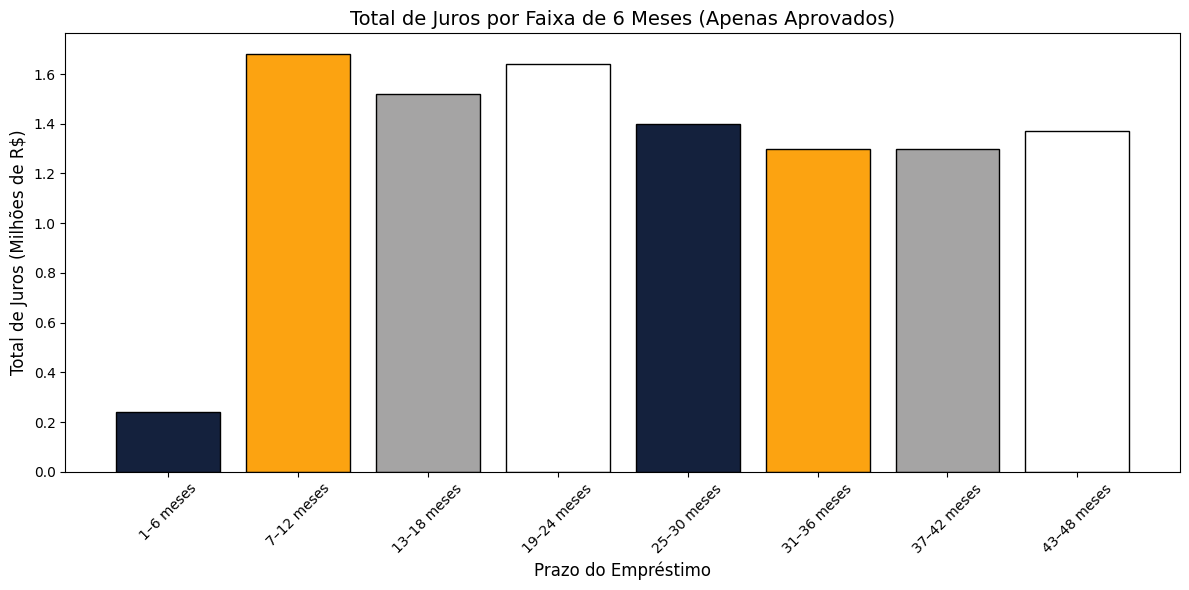

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------
#  Filtrar somente os aprovados
# ----------------------------------------------------
df_aprovados = df[df["approved"] == 1].copy()

# Calcular juros reais
df_aprovados["interest_fraction"] = df_aprovados["interest_rate"] / 100
df_aprovados["total_interest"] = df_aprovados["loan_amount"] * df_aprovados["interest_fraction"]

# ----------------------------------------------------
# Criar faixas de 6 meses
# ----------------------------------------------------
bins = np.arange(1, 55, 6)  # 1–6, 7–12, ..., 49–54
labels = [f"{bins[i]}–{bins[i+1]-1} meses" for i in range(len(bins)-1)]

df_aprovados["term_range"] = pd.cut(
    df_aprovados["Loan_Term_Months"],
    bins=bins,
    labels=labels,
    right=False
)

# ----------------------------------------------------
# Somar juros por faixa
# ----------------------------------------------------
interest_by_range = df_aprovados.groupby("term_range")["total_interest"].sum()

# Converter para milhões
interest_millions = (interest_by_range / 1_000_000).round(2)

# Mostrar tabela formatada
print("\n🔹 Total de juros por faixa (em milhões):\n")
print(interest_millions)

print("\n Soma total lucro (milhões):", round(interest_millions.sum(), 2), "mi\n")

# ----------------------------------------------------
# Gráfico em milhões
# ----------------------------------------------------
color_palette = ['#14213d', '#fca311', "#a5a4a4", '#ffffff']
colors = [color_palette[i % len(color_palette)] for i in range(len(interest_millions))]

plt.figure(figsize=(12, 6))
plt.bar(interest_millions.index, interest_millions.values, 
        color=colors, edgecolor='black')

plt.title("Total de Juros por Faixa de 6 Meses (Apenas Aprovados)", fontsize=14)
plt.xlabel("Prazo do Empréstimo", fontsize=12)
plt.ylabel("Total de Juros (Milhões de R$)", fontsize=12)
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()
